In [1]:
import warnings
warnings.filterwarnings('ignore')

import glob

import pandas as pd
import numpy as np

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

## 01 데이터 병합 및 전처리

In [2]:
# 해당연도 출생아
birth_age = ['0세']

# 영유아 : 7세 이하
infant_max_age = 7
infant_age = ['{}세'.format(age) for age in range(0, infant_max_age + 1)]

# 유소년 인구 기준 : 14세 이하
yount_max_age = 14
youth_people_age = ['{}세'.format(age) for age in range(0, yount_max_age + 1)]

# 가임 여성 인구 수 : 20세 ~ 39세
max_young_women_age = 39
young_women_age = ['{}세'.format(age) for age in range(20, max_young_women_age + 1)]

# 고령인구 수 : 65세 이상
old_min_age = 65
old_people_age = ['{}세'.format(age) for age in range(old_min_age, 100)]
old_people_age.append('100세 이상')

In [3]:
def data_merge(file_name, drop_columns= []):
    data_files = glob.glob(f'./Data/01RAW/행정구역_{file_name}_*.xlsx')
    data_files.sort()

    df = pd.DataFrame()

    for i, file in enumerate(data_files):
        tmp_df = pd.read_excel(file)
        tmp_df['행정구역(시도)'].fillna(method= 'ffill', inplace= True)

        if i == 0:
            df = pd.concat([df, tmp_df], axis= 1)

        else:
            df = df.merge(tmp_df, how= 'outer', on=['행정구역(시도)', '행정구역(시군구)별', '연령별'])

    df.dropna(inplace= True)            # 추후에 수정 해야함, 광역시의 경우 앞에 광역시명 붙이기

    columns = list(df.columns)
    year_columns = dict()
    if '연령별' in columns:
        for year in columns[3:]:
            year_columns[year] = np.int64

    else:
        for year in columns[2:]:
            year_columns[year] = np.int64

    df = df.astype(year_columns)
    if len(drop_columns) > 0:
        df = df.drop(drop_columns, axis= 1)

    df = df.sort_values(['행정구역(시도)', '행정구역(시군구)별'])

    df.to_csv('./Data/01RAW/행정구역_{}_전체.csv'.format(file_name), index= False, encoding= 'utf-8-sig')
    return df

In [4]:
# drop_years = ['2012 년', '2013 년', '2014 년', '2015 년']
drop_years = list()
remove_years = ['2012 년']

# 총인구
total_df = data_merge('총인구', drop_years)
# print(total_df.columns)

# 남자
men_df = data_merge('남자', drop_years)
# print(men_df.columns)

# 여자
women_df = data_merge('여자', drop_years)
# print(women_df.columns)

years_col = total_df.columns.drop(['행정구역(시도)', '행정구역(시군구)별', '연령별'])
years_col = [x.replace(' 년', '') for x in years_col]

for year in [x.replace(' 년', '') for x in remove_years]:
    years_col.remove(year)

print(years_col)

KeyError: '행정구역(시도)'

In [5]:
# 각 기준 별 인구 데이터 추출
def population_guideline(dataframe, guide_age, group_col= ['행정구역(시도)', '행정구역(시군구)별']):
    tmp_df = dataframe[dataframe['연령별'].isin(guide_age)]
    tmp_df = tmp_df.groupby(group_col).sum()
    tmp_df.drop(['연령별'], axis= 1, inplace= True)
    tmp_df.reset_index(inplace= True, drop= False)

    return tmp_df

# 각 시도 인구 비율 추출
def population_rate(numerator, denominator, remove_year= [], guid_col= ['행정구역(시도)', '행정구역(시군구)별']):
    numerator = numerator.merge(denominator[guid_col], how= 'inner', on= guid_col)
    denominator = denominator.merge(numerator[guid_col], how= 'inner', on= guid_col)
    # numerator = numerator.sort_values(guid_col)
    # denominator = denominator.sort_values(guid_col)

    numerator = numerator.set_index(guid_col)
    denominator = denominator.set_index(guid_col)
    
    rate_df = numerator.div(denominator, axis= 'columns', level= guid_col)
    rate_df.reset_index(inplace= True, drop= False)
    rate_df.drop(remove_year, axis= 1, inplace= True)

    return rate_df

# 시계열 데이터 하나의 Column으로 변환
def series_to_dataframe(dataframe, cat, drop_col= ['행정구역(시도)', '행정구역(시군구)별']):
    tmp_frame = pd.Series(dataframe[dataframe.columns.drop(drop_col)].values.tolist(), name= cat).to_frame()
    col_frame = dataframe[drop_col]

    return pd.concat([col_frame, tmp_frame], axis= 1)

# DataFrame Merge
def dataframe_merge(original_df, add_df, on_col= ['행정구역(시도)', '행정구역(시군구)별'], how= 'inner'):
    return original_df.merge(add_df, on= on_col, how= how)

In [6]:
# 분석 Dataframe
analysis_df = pd.DataFrame()

# 각 시도 별 전체 인구
total_df_sum = total_df.groupby(['행정구역(시도)', '행정구역(시군구)별']).sum()
total_df_sum.drop(['연령별'], axis= 1, inplace= True)
total_df_sum.reset_index(inplace= True, drop= False)

In [7]:
# 가임여성
young_women_df = population_guideline(women_df, young_women_age)            # 가임여성 인구수
young_women_rate = population_rate(young_women_df, total_df_sum, remove_years)         # 가임여성 인구비율
young_women_rate_df = series_to_dataframe(young_women_rate, cat= '가임여성비율')

# 고령
old_people_df = population_guideline(total_df, old_people_age)              # 고령 인구수
old_people_rate = population_rate(old_people_df, total_df_sum, remove_years)           # 고령 인구비율
old_people_rate_df = series_to_dataframe(old_people_rate, cat= '고령인구비율')

# 지방소멸지수
extinction_index = population_rate(young_women_df, old_people_df, remove_years)           # 지방소멸지수 = 가임여성인구수 / 고령인구수 
analysis_df = series_to_dataframe(extinction_index, cat= '지방소멸지수')

analysis_df = dataframe_merge(analysis_df, young_women_rate_df)
analysis_df = dataframe_merge(analysis_df, old_people_rate_df)

In [8]:
# 유소년인구
youth_people_df = population_guideline(total_df, youth_people_age)

# 유소년인구 비율
youth_people_rate = population_rate(youth_people_df, total_df_sum, remove_years)
youth_people_rate_df = series_to_dataframe(youth_people_rate, cat= '유소년비율')

analysis_df = dataframe_merge(analysis_df, youth_people_rate_df)

In [9]:
# 신생아 인구
birth_people_df = population_guideline(total_df, birth_age)

# 신생아 인구비율
birth_people_rate = population_rate(birth_people_df, total_df_sum, remove_years)
birth_people_rate_df = series_to_dataframe(birth_people_rate, cat= '신생아비율')

analysis_df = dataframe_merge(analysis_df, birth_people_rate_df)

In [10]:
# 신생아 인구
infant_df = population_guideline(total_df, infant_age)

# 신생아 인구비율
infant_rate = population_rate(infant_df, total_df_sum, remove_years)
infant_rate_df = series_to_dataframe(infant_rate, cat= '영유아비율')

analysis_df = dataframe_merge(analysis_df, infant_rate_df)

In [11]:
# 청년층 전체 인구 수
young_total_df = population_guideline(total_df, young_women_age)

# 청년층 인구 비율
men_women_rate = population_rate(young_women_df, young_total_df, remove_years)
men_women_rate_df = series_to_dataframe(men_women_rate, cat= '청년남여비율')

analysis_df = dataframe_merge(analysis_df, men_women_rate_df)

In [12]:
# 사회적인구 증감(전입 - 전출)
population_social_df = data_merge('사회적이동', drop_years)
population_social_rate = population_rate(population_social_df, total_df_sum, remove_years)
population_social_rate_df = series_to_dataframe(population_social_rate, cat= '사회적이동비율')

analysis_df = dataframe_merge(analysis_df, population_social_rate_df)

# 1인 사회적인구 증감(전입 - 전출)
population_social_1per_df = data_merge('사회적이동(1인)', drop_years)
population_social_1per_rate = population_rate(population_social_df, total_df_sum, remove_years)
population_social_1per_rate_df = series_to_dataframe(population_social_rate, cat= '1인사회적이동비율')

analysis_df = dataframe_merge(analysis_df, population_social_1per_rate_df)

In [13]:
# 외국인(한국국적취득, 외국인 주민 자녀) 인구 수
foreigner_df = data_merge('외국인', drop_years)

foreigner_rate = population_rate(foreigner_df, total_df_sum.drop(total_df_sum.columns[-1], axis= 1))
foreigner_rate_df = series_to_dataframe(foreigner_rate, cat= '외국인인구비율')
analysis_df = dataframe_merge(analysis_df, foreigner_rate_df)

## 02 Input 시계열 데이터

In [14]:
# 분석 데이터
analysis_dict = {
    # test : [english_name, ylabel]
    '지방소멸지수' : ['Extinction Index', 'Index'],
    # '가임여성비율' : ['Young Women Rate', 'Rate'],
    # '고령인구비율' : ['Old People Rate', 'Rate'],
    # '유소년비율' : ['Youth Rate', 'Rate'],
    # '신생아비율' : ['Birth Rate', 'Rate'],
    # '영유아비율' : ['Infant Rate', 'Rate'],
    '청년남여비율' : ['Young Women Rate in Young Population', 'Rate'],
    # '사회적이동비율' : ['Scocial Population Rate', 'Rate'],
    '1인사회적이동비율' : ['1Per Social Population Rate', 'Rate'],
    '외국인인구비율' : ['Foreigner Rate', 'Rate']    
}

In [15]:
timeseries_data = np.array(analysis_df[list(analysis_dict.keys())].values.tolist())
timsseries_flatten = np.reshape(timeseries_data, (timeseries_data.shape[0], -1))

In [16]:
def find_best_K(input_data, min_num= 2, max_num= 20, metric= 'euclidean'):
    # metric = {"euclidean", "dtw", "softdtw"} (기본값: "euclidean")
    # inertia values, silhouette score, model list
    inertia_, silhouette_score_, models_ = list(), list(), list()

    for k in range(min_num, max_num + 1):
        ts_kmeans = TimeSeriesKMeans(n_clusters= k, verbose=False, random_state=42, n_jobs= -1, max_iter= 100, metric= metric)
        y_pred = ts_kmeans.fit_predict(input_data)

        # K-Means Model
        models_.append(ts_kmeans)

        # Inertia Score
        inertia_.append(ts_kmeans.inertia_)

        # Silhouette Score
        s_score = silhouette_score(X= input_data, labels= y_pred, metric= metric, verbose=False, random_state=42, n_jobs= -1)
        silhouette_score_.append(s_score)

    return models_, inertia_, silhouette_score_

In [17]:
min_cluster_num, max_cluster_num = 2, 20
# metrics = ['euclidean', 'dtw', 'softdtw']

models, inertias, silhouettes = find_best_K(
    input_data= timsseries_flatten, 
    min_num= min_cluster_num, 
    max_num= max_cluster_num,
    metric= 'dtw'
)

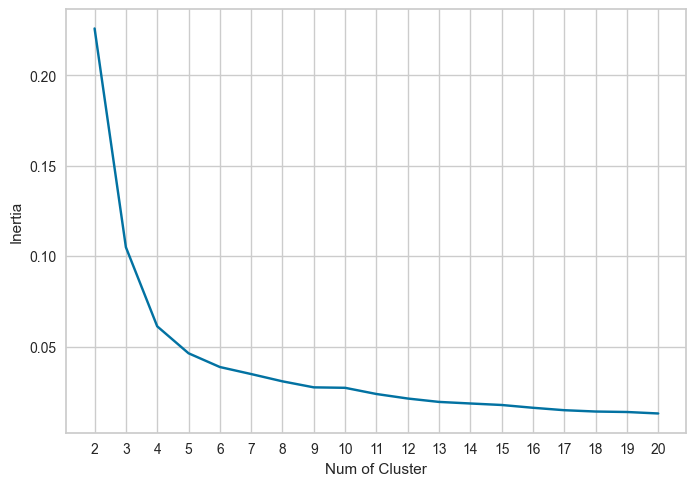

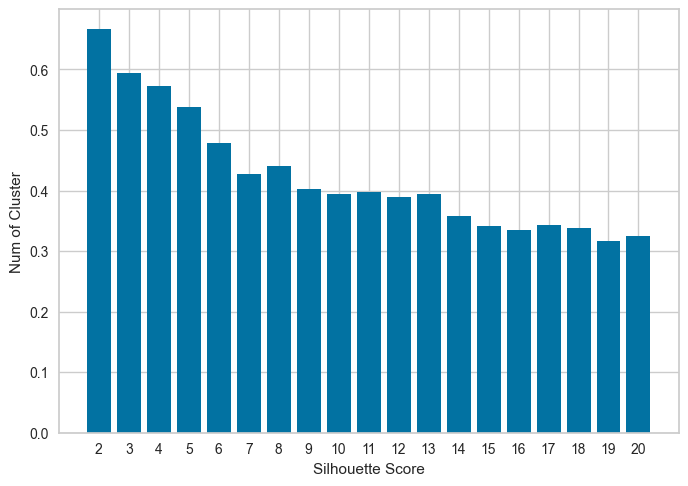

In [18]:
# 결과 시각화
X_range = [x for x in range(min_cluster_num, max_cluster_num + 1)]

# Elbow Methods
plt.figure()
# plt.subplot(1, 2, 1)
plt.plot(X_range, inertias)
plt.xticks(X_range)
plt.xlabel('Num of Cluster')
plt.ylabel('Inertia')
plt.show()

# Sihouettes Score
plt.figure()
# plt.subplot(1, 2, 2)
plt.bar(X_range, silhouettes)
plt.xticks(X_range)
plt.xlabel('Silhouette Score')
plt.ylabel('Num of Cluster')
plt.show()

0.5733424523393875


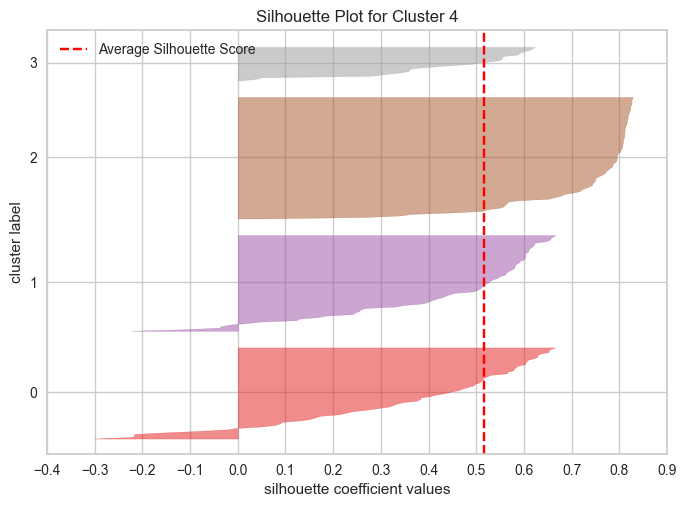

<Axes: title={'center': 'Silhouette Plot for Cluster 4'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [19]:
Best_K = 4
kmeans_model = models[Best_K - min_cluster_num]

print(silhouettes[Best_K - min_cluster_num])

# 최적의 클러스터의 Silhouette 분포 시각화
silhouette_vis = SilhouetteVisualizer(
    kmeans_model,
    title= 'Silhouette Plot for Cluster {}'.format(Best_K)
)
silhouette_vis.fit(timsseries_flatten)
silhouette_vis.show()

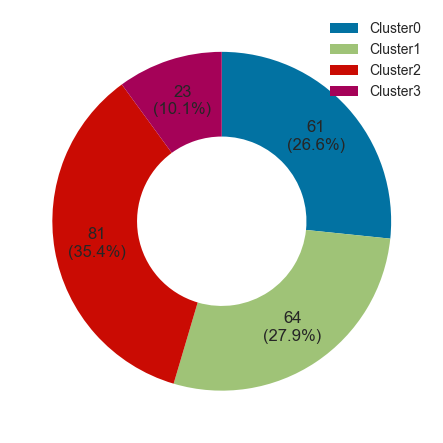

In [20]:
y_pred = kmeans_model.fit_predict(timsseries_flatten)
pred_series = pd.Series(y_pred, name= 'Cluster Pred').to_frame()
pre_df = pd.concat([analysis_df, pred_series], axis= 1)

labels = pre_df['Cluster Pred'].value_counts().sort_index().index
frequency = pre_df['Cluster Pred'].value_counts().sort_index().values

fig = plt.figure()
ax = fig.add_subplot()                                      # 프레임 생성

pie = ax.pie(
    frequency,
    counterclock= False,
    startangle=90,
    wedgeprops= {'width' : 0.5}
)

total = np.sum(frequency)                                   # 빈도수 총합
 
sum_pct = 0                                                 # 백분율 초기값
for i,l in enumerate(labels):
    ang1, ang2 = pie[0][i].theta1, pie[0][i].theta2         # 각1, 각2
    r = pie[0][i].r                                         # 원의 반지름
    
    x = ((r+0.5)/2)*np.cos(np.pi/180*((ang1+ang2)/2))       # 정중앙 x좌표
    y = ((r+0.5)/2)*np.sin(np.pi/180*((ang1+ang2)/2))       # 정중앙 y좌표
    
    if i < len(labels) - 1:
        sum_pct += float(f'{frequency[i]/total*100:.1f}')   # 백분율을 누적한다.
        ax.text(x,y,f'{frequency[i]}\n({frequency[i]/total*100:.1f}%)',ha='center',va='center')
    else:
        ax.text(x,y,f'{frequency[i]}\n({100-sum_pct:.1f}%)',ha='center',va='center')

plt.legend(['Cluster{}'.format(idx) for idx in labels])
plt.show()

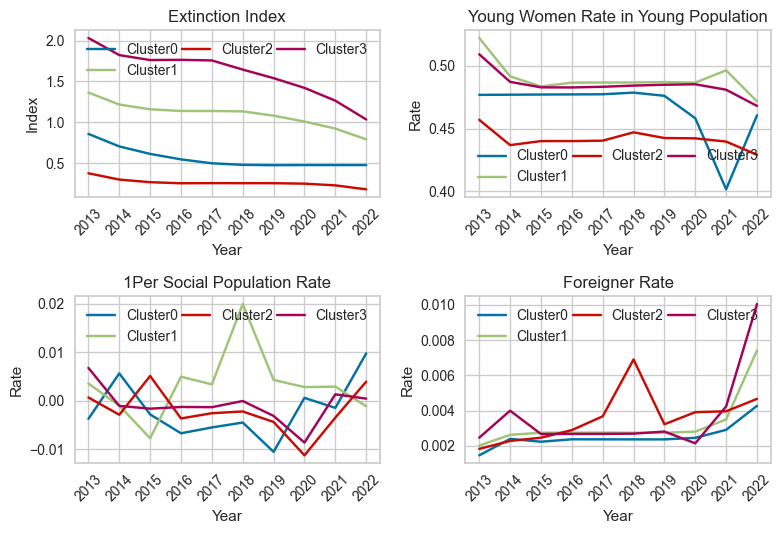

In [21]:
cluster_center = kmeans_model.cluster_centers_
cluster_center = np.array(cluster_center).reshape(Best_K, len(analysis_dict), len(years_col))

v_num, h_num, total_num = 0, 2, len(analysis_dict)

if total_num % h_num == 0:
    v_num = total_num // h_num
else:
    v_num = (total_num //h_num) + 1

for i in range(1, total_num + 1):
    plt.subplot(v_num, h_num, i)
    for j in range(Best_K):
        plt.plot(years_col, cluster_center[j][i-1])
    plt.title(analysis_dict[list(analysis_dict.keys())[i-1]][0])
    plt.xticks(years_col, rotation=45)
    plt.ylabel(analysis_dict[list(analysis_dict.keys())[i-1]][1])
    plt.xlabel('Year')
    plt.legend(
        ['Cluster{}'.format(idx) for idx in range(Best_K)],
        ncol= 3, mode= 'expand'
    )

plt.tight_layout()
plt.show()

## Geo Visualization

In [22]:
korea_file = './Data/02Map/행정구역지도(전국)/sig.shp'
korea = gpd.read_file(korea_file, encoding= 'euckr')
korea = korea.astype({'SIG_CD' : int})

tmp_korea = pd.read_excel('./Data/행정구역Geo2.xlsx')
# tmp_korea = pd.read_excel('./Data/02Map/행정구역_인구감소지역_전체.xlsx')
tmp_korea.dropna(inplace= True)
tmp_korea = tmp_korea.astype({'SIG_CD' : int})
korea = korea[['SIG_CD', 'SIG_ENG_NM', 'SIG_KOR_NM', 'geometry']].merge(tmp_korea[['행정구역(시도)', '행정구역(시군구)별', 'SIG_CD', 'Group']], on= 'SIG_CD', how= 'inner')
# korea = korea[['SIG_CD', 'SIG_ENG_NM', 'SIG_KOR_NM', 'geometry']].merge(tmp_korea[['행정구역(시도)', '행정구역(시군구)별', 'SIG_CD', '인구감소지역']], on= 'SIG_CD', how= 'inner')
korea = korea[['SIG_CD', '행정구역(시도)', '행정구역(시군구)별', 'Group', 'SIG_ENG_NM', 'SIG_KOR_NM', 'geometry']]
# korea = korea[['SIG_CD', '행정구역(시도)', '행정구역(시군구)별', '인구감소지역', 'SIG_ENG_NM', 'SIG_KOR_NM', 'geometry']]

In [23]:
pre_df['Group'] = pre_df['행정구역(시군구)별'].apply(lambda x: x.split('(')[0])
pre_df['Check'] = pre_df[['행정구역(시군구)별', 'Group']].apply(lambda x: 1 if x[0] == x[1] else np.nan, axis= 1)

pre_df.dropna(inplace= True)
pre_df.drop('Check', axis= 1, inplace= True)

In [24]:
korea = korea.merge(
    pre_df[['행정구역(시도)', 'Group', 'Cluster Pred']],
    on = ['행정구역(시도)', 'Group'],
    how = 'inner'
)

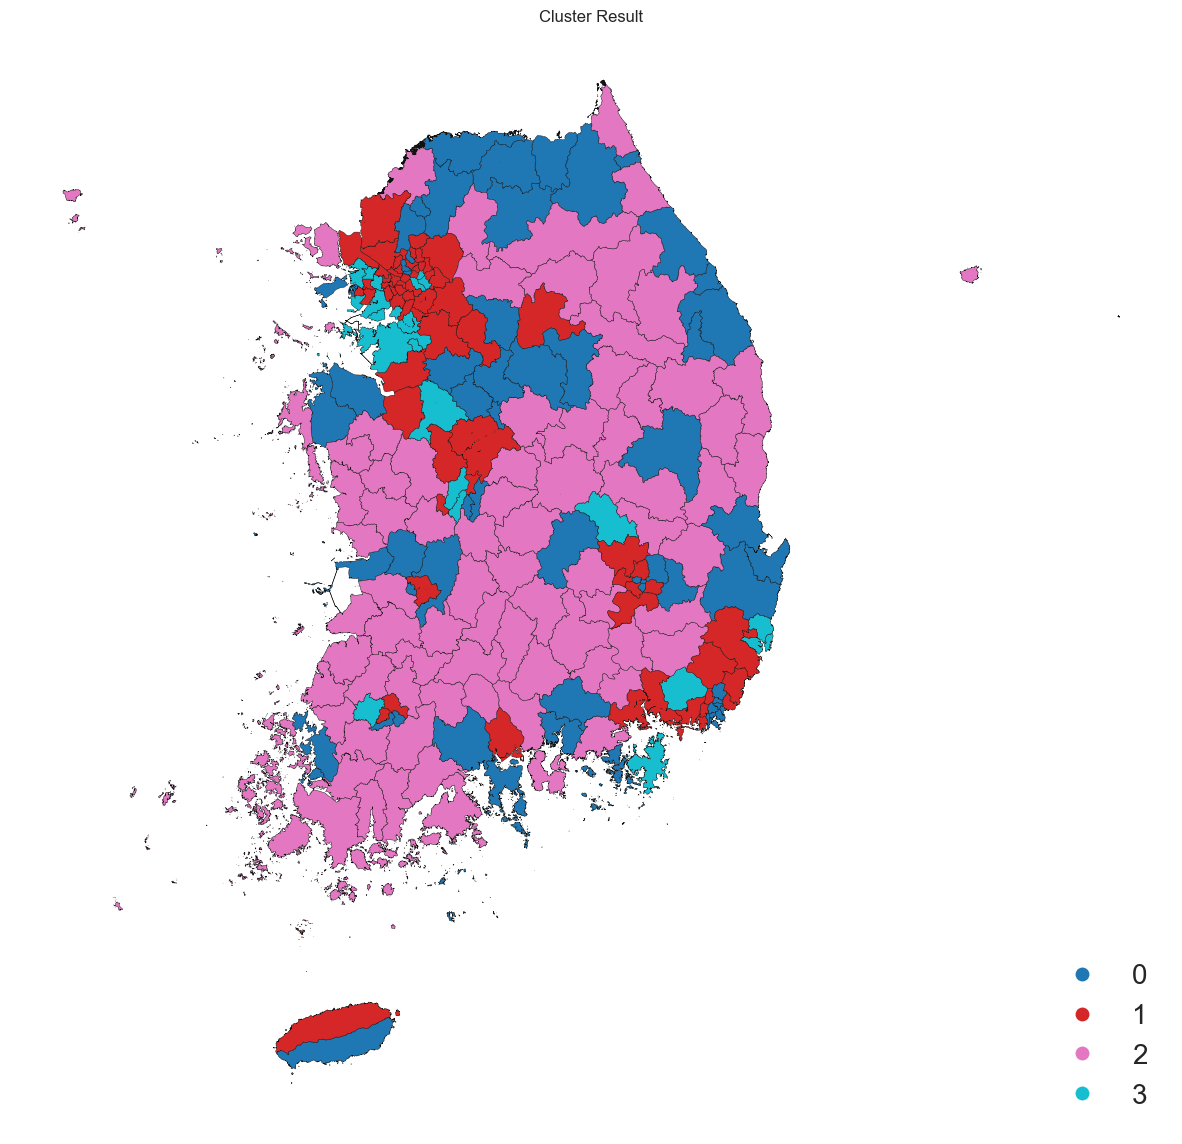

In [25]:
korea = korea.dissolve(by=['행정구역(시도)', 'Group']).reset_index()
# korea = korea.dissolve(by=['행정구역(시군구)별']).reset_index()
ax = korea.plot(figsize=(15, 15), column="Cluster Pred", categorical=True,
# ax = korea.plot(figsize=(15, 15), column="인구감소지역", categorical=True,
                cmap="tab10", edgecolor="k", legend=True, legend_kwds={'loc': 'lower right', 'fontsize' : 20})
ax.set_title("Cluster Result")
# ax.set_title("Population Decline Region")
ax.set_axis_off()
palette = sns.color_palette('Set3')
plt.show()